# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [36]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    # YOUR CODE HERE
    if len(y) == 0:
        return 0
    else:
        return np.sum(np.power((y - np.mean(y)), 2)) / len(y) #variance

In [37]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [38]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    # YOUR CODE HERE
    x_col = X[:, j]

    R_l = y[x_col <= t]
    R_r = y[x_col > t]
    tmp_r = H(R_r) / len(y)
    tmp_l = H(R_l) / len(y)
    Q = 0
    return len(R_l) * tmp_l + len(R_r) * tmp_r
    # return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [39]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [40]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """

        # To store best split parameters
        best_split_column = None
        best_threshold = None
        best_cost = H(y)
        best_information_gain = -999

        # Data impurity before the split
        # impurity = 0.8 (example)

        # For each column in X ...
        for split_column in range(X.shape[1]):

            # Select values of the column
            x_col = X[:, split_column]
            # x_col = [2.6, 1.3, 0.5, ...] (example)

            # For each value in the column ...
            for i_x in range(0, len(x_col)):

                # Take the value as a threshold for a split
                threshold = x_col[i_x]
                # threshold = 1.3 (example)

                # Make the split into right and left childs
                information_gain = best_cost - Q(X, y, split_column, threshold)
                # information_gain = 0.2 (example)

                # Is this information_gain the best?
                if information_gain > best_information_gain:
                    best_split_column = split_column
                    best_threshold = threshold
                    best_information_gain = information_gain

        # If no split available
        if best_information_gain == -999:
            return None, None, None, None, None, None

        # Take the best split parameters and make this split
        x_col = X[:, best_split_column]
        X_left = X[x_col <= best_threshold, :]
        y_left = y[x_col <= best_threshold]
        X_right = X[x_col > best_threshold, :]
        y_right = y[x_col > best_threshold]

        return best_split_column, best_threshold, X_left, y_left, X_right, y_right

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal =True
            return

        # Check termination conditions
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        # Make best split
        split_column, threshold, X_left, y_left, X_right, y_right = self.best_split(X, y) # Make a split
        # split_column = 2 (exmaple) column index of the split
        # threshold = 2.74 (example) split_column > threshold

        # Check additional termination conditions
        if split_column is None:
            node.is_terminal = True
            return
        if len(X_left) < self.min_samples_leaf or len(X_right) < self.min_samples_leaf:  # min_samples_leaf check
            node.is_terminal = True
            return


        # Add split parameters into the current node
        node.column = split_column
        node.threshold = threshold

        # Create a left child of the current node
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        # Create a right child of the current node
        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)

        # Make splits for the left and right nodes
        self.grow_tree(node.right, X_right, y_right)
        self.grow_tree(node.left, X_left, y_left)


    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True

        # Initialize the tree (root node)
        self.tree_ = Node()
        self.tree_.depth = 0
        self.tree_.prediction = np.mean(y)

        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        # YOUR CODE HERE

        if node.is_terminal:
            return node.prediction
        if x[node.column] > node.threshold:
            y_pred = self.get_prediction(node.right, x)
        else:
            y_pred = self.get_prediction(node.left, x)
        return y_pred

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [41]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

C:\anaconda\lib\site-packages\sklearn\utils\estimator_checks.py:3608: FutureWarning: As of scikit-learn 0.23, estimators should expose a n_features_in_ attribute, unless the 'no_validation' tag is True. This attribute should be equal to the number of features passed to the fit method. An error will be raised from version 1.0 (renaming of 0.25) when calling check_estimator(). See SLEP010: https://scikit-learn-enhancement-proposals.readthedocs.io/en/latest/slep010/proposal.html
  warnings.warn(
C:\anaconda\lib\site-packages\sklearn\utils\estimator_checks.py:3652: FutureWarning: As of scikit-learn 0.23, estimators should have a 'requires_y' tag set to the appropriate value. The default value of the tag is False. An error will be raised from version 1.0 when calling check_estimator() if the tag isn't properly set.
  warnings.warn(warning_msg, FutureWarning)


### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model

In [42]:
data = load_boston()
features_train, features_test, target_train, target_test = train_test_split(data.data, data.target, test_size = 0.25, random_state = 12345)

C:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fun

В методе fit пришлось поменять <code>max_depth = 0</code>, иначе пришлось бы тут указывать глубину не 1, как в условии, а 2 или больше.

In [43]:
model_tree = MyDecisionTreeRegressor(max_depth=1)
model_tree.fit(features_train, target_train)

MyDecisionTreeRegressor(max_depth=1)

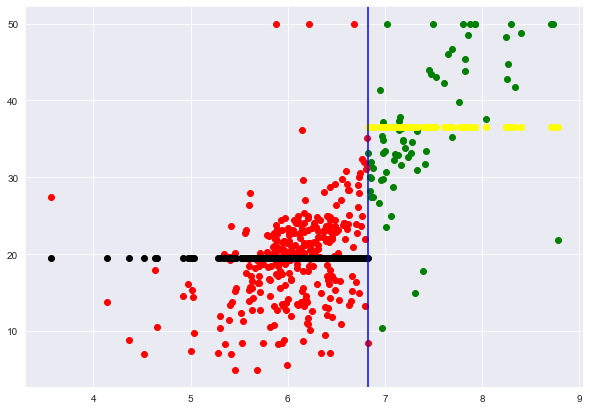

In [44]:
model_tree_predicted = model_tree.predict(features_train)
tmp_col = features_train[:, model_tree.tree_.column]

plt.gcf().set_size_inches(10, 7);

plt.scatter(features_train[tmp_col <= model_tree.tree_.threshold][:, model_tree.tree_.column], target_train[tmp_col <= model_tree.tree_.threshold], color='red')

plt.scatter(features_train[tmp_col > model_tree.tree_.threshold][:, model_tree.tree_.column], target_train[tmp_col > model_tree.tree_.threshold], color='green')

plt.scatter(features_train[tmp_col <= model_tree.tree_.threshold][:, model_tree.tree_.column], model_tree_predicted[tmp_col <= model_tree.tree_.threshold], color ='black')

plt.scatter(features_train[tmp_col > model_tree.tree_.threshold][:, model_tree.tree_.column], model_tree_predicted[tmp_col > model_tree.tree_.threshold], color ='yellow')

plt.axvline(model_tree.tree_.threshold, color = 'blue');

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

Лучшие параметры: {'max_depth': 5, 'min_samples_split': 5}

Лучший счет: -4.610205735534387

CPU times: total: 14min 47s
Wall time: 14min 50s


2 15
2 10

In [45]:
parameters = {"max_depth":range(1,4),'min_samples_leaf':range(1,6)}
model = MyDecisionTreeRegressor()
grid = GridSearchCV(model, parameters, scoring='neg_mean_absolute_error', verbose=4)
grid.fit(features_train, target_train)
print('Лучшие параметры:', grid.best_params_, '\n')
print('Лучший счет:', grid.best_score_, '\n')

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END ..max_depth=1, min_samples_leaf=1;, score=-5.457 total time=   0.1s
[CV 2/5] END ..max_depth=1, min_samples_leaf=1;, score=-5.343 total time=   0.1s
[CV 3/5] END ..max_depth=1, min_samples_leaf=1;, score=-5.269 total time=   0.1s
[CV 4/5] END ..max_depth=1, min_samples_leaf=1;, score=-5.043 total time=   0.1s
[CV 5/5] END ..max_depth=1, min_samples_leaf=1;, score=-5.454 total time=   0.1s


KeyboardInterrupt: 

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points

**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [ ]:
def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in
    Returns
    -------
    bias2 : float,
        Estiamted squared bias
    variance : float,
        Estiamted variance
    """
    np.random.seed(12345)

    # YOUR CODE HERE
    #TypeError: only integer scalar arrays can be converted to a scalar index
    data_tmp = pd.DataFrame([], index=range(len(y)))
    # for i in range(n_iter):
    #     data_tmp[i] = np.nan

    for i in range(n_iter):
        bootstrap = np.random.choice(len(y), len(y))

        OOB_indexes = np.arange(len(y))[~np.isin(np.arange(len(y)),bootstrap)]
        OOB = x[OOB_indexes, :]

        estimator.fit(x[bootstrap, :], y[bootstrap])
        predictions = estimator.predict(OOB)

        columns = pd.Series([np.nan] * len(y))
        columns = np.array(columns)

        np.put(columns, OOB_indexes, predictions)

        # display(pd.Series(columns))

        # display(pd.Series(columns))
        data_tmp[i] = pd.Series(columns)


        #Note: You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.Note: You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.
        # for index in data_tmp.index:
        #     if index in OOB_indexes:
        #         data_tmp.loc[index, i] = predictions[index]
        # display(data_tmp)
        # my_iter = iter(predictions)
        # print(OOB_indexes)
        # for j in range(len(y)):
        #     if j in OOB_indexes:
        #         print('J', j)
        #         index = list(OOB_indexes).index(j)
        #         print('INDEX', index)
        #         data_tmp.at[i, index] = next(my_iter)
        # display(data_tmp)


    return np.nanmean(np.square(y - np.nanmean(data_tmp, axis = 1))), np.nanmean(np.nanvar(data_tmp, axis=1))

In [ ]:
%%time
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, features_train, target_train, 10)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

In [ ]:
%%time
np.random.seed(12345)

bias_lst = []
variance_lst = []

for sample in range(0, 51, 10):
    model = MyDecisionTreeRegressor(max_depth=10, min_samples_split=sample)
    bias, variance = get_bias_variance(model, features_train, target_train, 10)
    bias_lst.append(bias)
    variance_lst.append(variance)
plt.plot(range(0, 51, 10), bias_lst, label='bias')
plt.plot(range(0, 51, 10), variance_lst, label='variance')
plt.legend()
plt.show()

``` С увличением min_samples_split дисперсия уменьшается, что говорит о том, что данные становятся более кучными и модель становится лучше. bias же практически не изменяется, но в целом он и не должен, он бы убывал, если бы кол-во деревьев бы возрастало.```

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(max_depth=8, min_samples_split=15), n_estimators=10, random_state=12345)

get_bias_variance(model, features_train, target_train, 10)

```your comments here```

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task.

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values

Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.

Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# YOUR CODE HERE
# define column_transformer

# Transform the data
features_train = column_transformer.fit_transform(features_train)
features_test = column_transformer.transform(features_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression

* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to implement one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

To get method that you have to implement, run cell below and input your name in Russian (for example, if you input Андрей, you will see that user with this name should implement xgboost)

In [ ]:
def assign_method():
    name = input()
    methods = ['xgboost', 'lightgbm', 'catboost']
    idx = sum([ord(x) for x in list(name)]) % 3
    print('Реализуйте', methods[idx])

assign_method()

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [ ]:
# YOUR CODE HERE

```your comments here```

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

In [ ]:
# YOUR CODE HERE